思路：数据探索，做一点点的修改-->数据清洗(空值的填充)-->数据预处理（数据的归一化，标准化等）-->模型构建-->训练预测-->保存提交

## 导入相应的包

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as ppf
import warnings##忽略警告
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

这里需要导入一些包，用来做特征工程的

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
from sklearn.preprocessing import Imputer

## 检视原数据

In [39]:
train = pd.read_csv("dataset/train.csv")

In [40]:
test = pd.read_csv("dataset/test.csv")

In [41]:
train.head()#默认显示前五行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


这样子大家应该一眼就能看出哪些是需要处理的吧

## 数据探索性分析 pandas_profiling

In [43]:
ppf.ProfileReport(train)

Summarize dataset:   0%|          | 0/94 [00:00<?, ?it/s]

KeyboardInterrupt: 

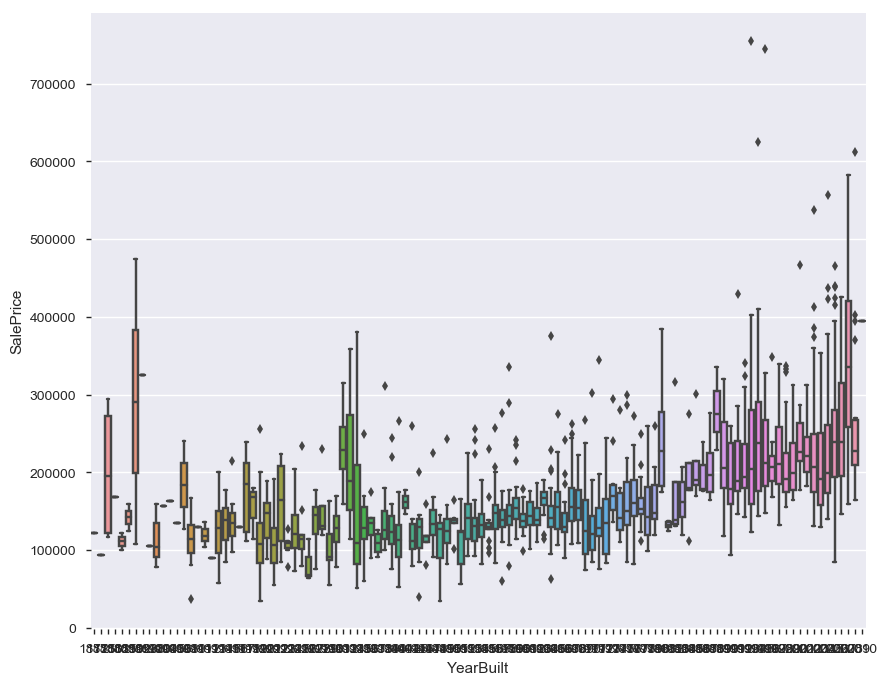

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(train.YearBuilt, train.SalePrice)##箱型图是看异常值的，离群点

(0, 800000)

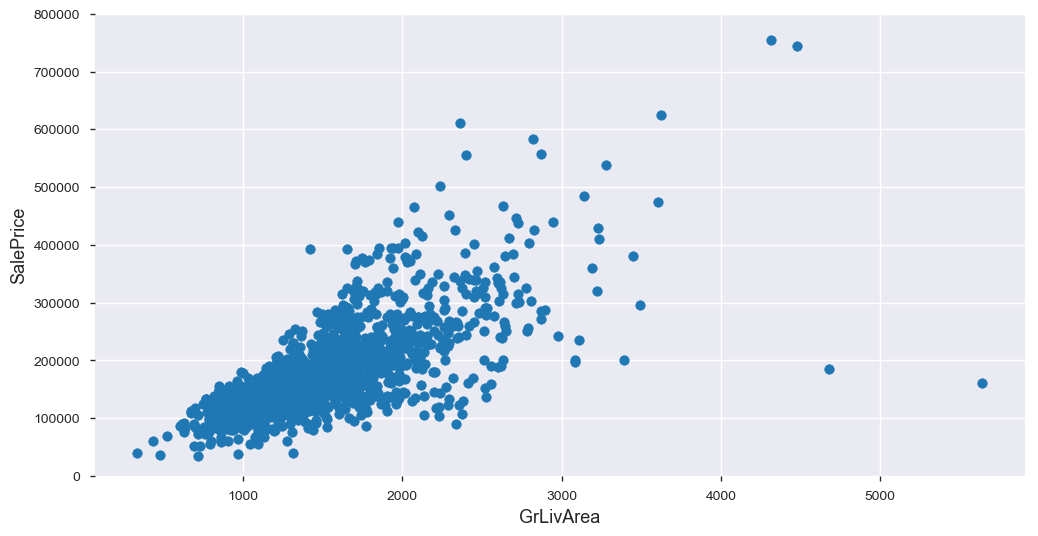

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)##可以用来观察存在线型的关系
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [10]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)#pandas 里面的条件索引

In [11]:
full = pd.concat([train,test],ignore_index=True)

In [12]:
full.drop("Id",axis=1,inplace=True)

In [13]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [14]:
# full.info()#查看数据的一个信息

# 数据清洗--空值填充、空值的删除，不处理

In [44]:
##查看缺失值，并且缺失的个数要从高到低排序

In [45]:
miss = full.isnull().sum()#统计出空值的个数

In [46]:
miss[miss>0].sort_values(ascending=True)#由低到高排好序

SalePrice    1459
dtype: int64

In [47]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2917 non-null   int64  
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          2917 non-null   int64  
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2917 non-null   int64  
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

## 空值的填充与删除

对字符类型的进行填充

In [48]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None",inplace=True)

对数值类型的进行填充

In [49]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

对lotfrontage的空值进行填充（用这一列的均值）

In [50]:
full["LotFrontage"].fillna(np.mean(full["LotFrontage"]),inplace=True)

对这些列进行众数填充

In [51]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

查看哪些是还没填充好的，发现只有test的没有标签列

In [52]:
full.isnull().sum()[full.isnull().sum()>0]##至此我们已经把空值填充好了

SalePrice    1459
dtype: int64

## 数据预处理--字符变成数值型这是很重要的

将一些数字特征转换为类别特征。最好使用LabelEncoder和get_dummies来实现这些功能。

In [53]:
full["MSZoning"].mode()[0]

3

In [54]:
for col in cols2:
    full[col]=full[col].astype(str)##astype来进行数据转换成字符串类型

In [55]:
lab = LabelEncoder()

In [56]:
full["Alley"] = lab.fit_transform(full.Alley)
full["PoolQC"] = lab.fit_transform(full.PoolQC)
full["MiscFeature"] = lab.fit_transform(full.MiscFeature)
full["Fence"] = lab.fit_transform(full.Fence)
full["FireplaceQu"] = lab.fit_transform(full.FireplaceQu)
full["GarageQual"] = lab.fit_transform(full.GarageQual)
full["GarageCond"] = lab.fit_transform(full.GarageCond)
full["GarageFinish"] = lab.fit_transform(full.GarageFinish)
full["GarageYrBlt"] = full["GarageYrBlt"].astype(str)
full["GarageYrBlt"] = lab.fit_transform(full.GarageYrBlt)
full["GarageType"] = lab.fit_transform(full.GarageType)
full["BsmtExposure"] = lab.fit_transform(full.BsmtExposure)
full["BsmtCond"] = lab.fit_transform(full.BsmtCond)
full["BsmtQual"] = lab.fit_transform(full.BsmtQual)
full["BsmtFinType2"] = lab.fit_transform(full.BsmtFinType2)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)
full["MasVnrType"] = lab.fit_transform(full.MasVnrType)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)

In [57]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,Pave,1,Reg,Lvl,0,Inside,...,0,3,4,1,0,2,2008,8,Normal,208500.0
1,20,3,80.0,9600,Pave,1,Reg,Lvl,0,FR2,...,0,3,4,1,0,5,2007,8,Normal,181500.0
2,60,3,68.0,11250,Pave,1,IR1,Lvl,0,Inside,...,0,3,4,1,0,9,2008,8,Normal,223500.0
3,70,3,60.0,9550,Pave,1,IR1,Lvl,0,Corner,...,0,3,4,1,0,2,2006,8,Abnorml,140000.0
4,60,3,84.0,14260,Pave,1,IR1,Lvl,0,FR2,...,0,3,4,1,0,12,2008,8,Normal,250000.0


In [58]:
full["MSZoning"] = lab.fit_transform(full.MSZoning)
full["BsmtFullBath"] = lab.fit_transform(full.BsmtFullBath)
full["BsmtHalfBath"] = lab.fit_transform(full.BsmtHalfBath)
full["Utilities"] = lab.fit_transform(full.Utilities)
full["Functional"] = lab.fit_transform(full.Functional)
full["Electrical"] = lab.fit_transform(full.Electrical)
full["KitchenQual"] = lab.fit_transform(full.KitchenQual)
full["SaleType"] = lab.fit_transform(full.SaleType)
full["Exterior1st"] = lab.fit_transform(full.Exterior1st)
full["Exterior2nd"] = lab.fit_transform(full.Exterior2nd)

In [59]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,Pave,1,Reg,Lvl,0,Inside,...,0,3,4,1,0,2,2008,8,Normal,208500.0
1,20,3,80.0,9600,Pave,1,Reg,Lvl,0,FR2,...,0,3,4,1,0,5,2007,8,Normal,181500.0
2,60,3,68.0,11250,Pave,1,IR1,Lvl,0,Inside,...,0,3,4,1,0,9,2008,8,Normal,223500.0
3,70,3,60.0,9550,Pave,1,IR1,Lvl,0,Corner,...,0,3,4,1,0,2,2006,8,Abnorml,140000.0
4,60,3,84.0,14260,Pave,1,IR1,Lvl,0,FR2,...,0,3,4,1,0,12,2008,8,Normal,250000.0


In [60]:
pd.unique(full['LotShape'])

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

In [61]:
help(pd.unique)

Help on function unique in module pandas.core.algorithms:

unique(values)
    Hash table-based unique. Uniques are returned in order
    of appearance. This does NOT sort.
    
    Significantly faster than numpy.unique for long enough sequences.
    Includes NA values.
    
    Parameters
    ----------
    values : 1d array-like
    
    Returns
    -------
    numpy.ndarray or ExtensionArray
    
        The return can be:
    
        * Index : when the input is an Index
        * Categorical : when the input is a Categorical dtype
        * ndarray : when the input is a Series/ndarray
    
        Return numpy.ndarray or ExtensionArray.
    
    See Also
    --------
    Index.unique : Return unique values from an Index.
    Series.unique : Return unique values of Series object.
    
    Examples
    --------
    >>> pd.unique(pd.Series([2, 1, 3, 3]))
    array([2, 1, 3])
    
    >>> pd.unique(pd.Series([2] + [1] * 5))
    array([2, 1])
    
    >>> pd.unique(pd.Series([pd.Timest

In [62]:
full.drop("SalePrice",axis=1,inplace=True)##删除

In [63]:
# full2 = pd.get_dummies(full)##独热编码

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
from sklearn.preprocessing import Imputer

## <font color=red>管道建设：pipeline--方便组合各种特征以及对特征的处理，方便后续的机器学习的特征的重做</font>

<font color=blue >https://blog.csdn.net/dss_dssssd/article/details/82824979 这是关于BaseEstimator，TransformerMixin 这两个类的说明</font>

个人试错经历：

数据预处理阶段：为了省事，然后把空值都删掉了（现在想起来真的丢人）

特征工程阶段：没有进行特征的组合以及特征的选择，处理完就直接放到模型里面去训练

模型的一个选择阶段：对于数据的理解不是很深刻，就单纯的采用一种单一的模型（当然这里除了kaggle神器xgb、lightgbm等等之外。）


In [65]:
##自己写一个转换函数
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    ##对三个年份来进行一个标签编码,这里可以随便自己添加
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        X["BldgType"] = lab.fit_transform(X["BldgType"])
        
        return X

In [66]:
#转换函数
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):#偏度
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])#而是去除了包含了对象数据类型，取出来绝大部分是数值型
        skewness = X_numeric.apply(lambda x: skew(x))#匿名函数，做成字典的形式
        skewness_features = skewness[abs(skewness) >= self.skew].index#通过条件来涮选出skew>=0.5的索引的条件，取到了全部数据，防止数据的丢失
        X[skewness_features] = np.log1p(X[skewness_features])#求对数，进一步让他更符合正态分布
        X = pd.get_dummies(X)##一键独热，独热编码，（试错经历）
        return X

In [67]:
# 构建管道
pipe = Pipeline([##构建管道的意思
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=2)),
    ])

In [68]:
# 保存原来的数据以备后用，为了防止写错
full2 = full.copy()

In [69]:
pipeline_data = pipe.fit_transform(full2)

In [70]:
pipeline_data.shape

(2917, 178)

In [40]:
pipeline_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave
0,856,854,0.0,1,3,0.0,1.609438,3,706.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,1262,0,0.0,1,3,0.0,1.609438,1,978.0,0.0,...,0,0,0,0,0,0,1,0,0,1
2,920,866,0.0,1,3,0.0,1.609438,2,486.0,0.0,...,0,0,0,0,0,0,1,0,0,1
3,961,756,0.0,1,3,0.0,0.693147,3,216.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,1145,1053,0.0,1,4,0.0,1.609438,0,655.0,0.0,...,0,0,0,0,0,0,1,0,0,1


In [41]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## <font color= red> 特征的选择--基于特征重要性图来选择</font>

In [42]:
from sklearn.linear_model import Lasso##运用算法来进行训练集的得到特征的重要性，特征选择的一个作用是，wrapper基础模型
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=pipeline_data.columns)#索引和重要性做成dataframe形式

In [44]:
FI_lasso.sort_values("Feature Importance",ascending=False)#由高到低进行排序

,Feature Importance
GrLivArea,0.124653
OverallQual,0.070760
YearBuilt,0.054572
TotalBsmtSF,0.045606
OverallCond,0.044655
LotArea,0.043423
BsmtFinSF1,0.022606
Neighborhood_Crawfor,0.021090
Neighborhood_Somerst,0.020794
GarageCars,0.019355


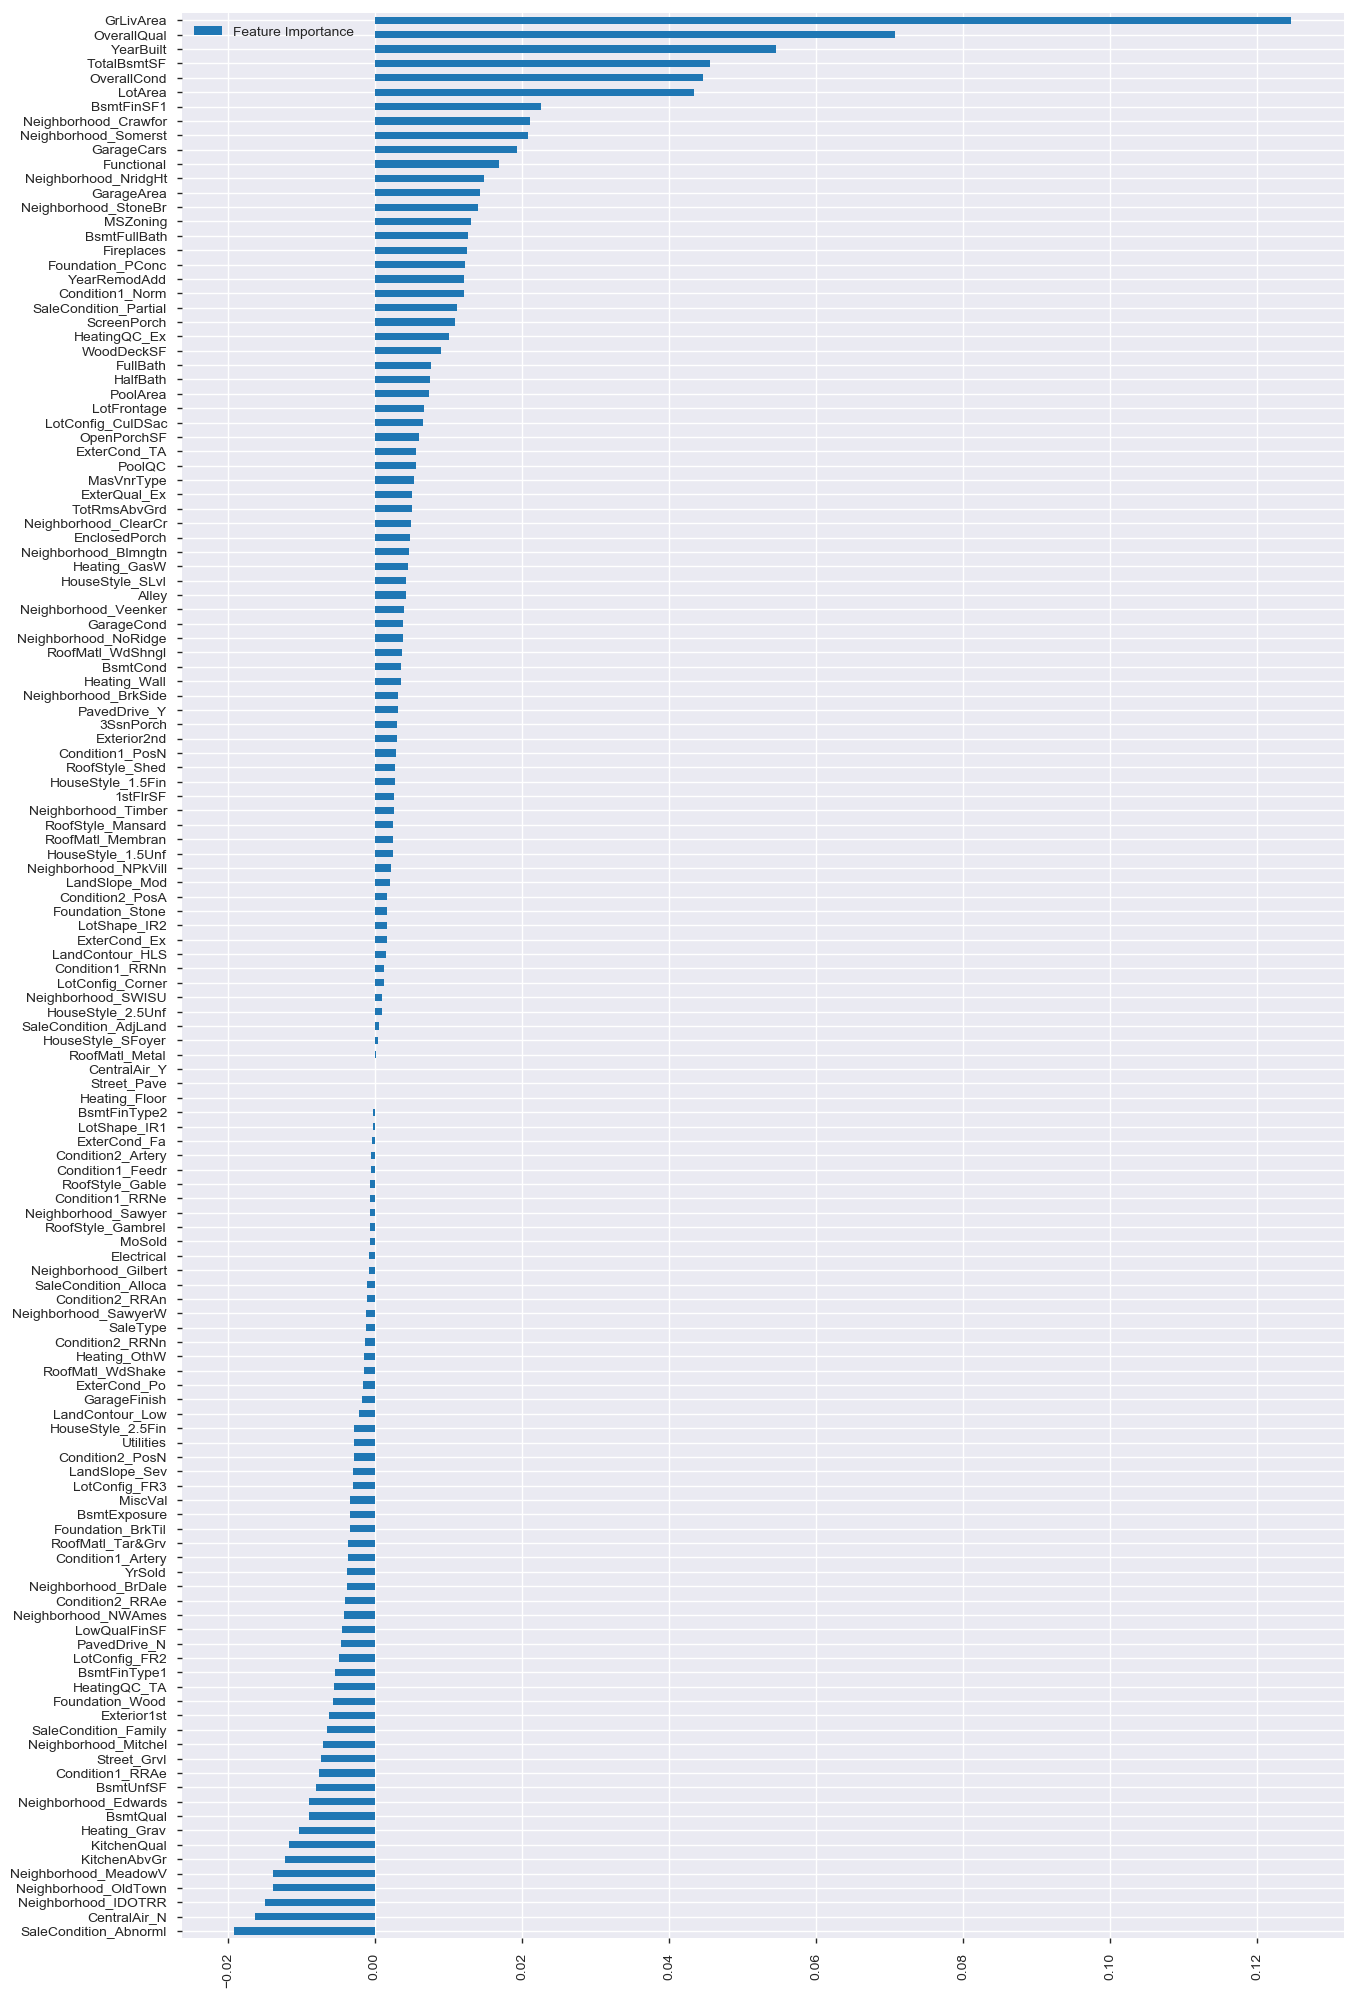

In [45]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()##画图显示

## <font color=red> 得到特征重要性图之后就可以进行特征选择与重做,这里也提供一条其他的思路，特征不重要的要删除</font>

In [46]:
##大家的发挥空间比较大，可以随意的定制，自己做两种特征
class add_feature(BaseEstimator, TransformerMixin):#自己定义转换函数--fit_transform由自己定义
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [47]:
pipe = Pipeline([#把后面的东西加到管道里面来
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=4)),
    ])

In [48]:
pipe

Pipeline(memory=None,
     steps=[('labenc', labelenc()), ('add_feature', add_feature(additional=2)), ('skew_dummies', skew_dummies(skew=4))])

In [49]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## 模型的构建

In [50]:
from sklearn.tree import DecisionTreeRegressor#导入模型

In [51]:
model = DecisionTreeRegressor()

In [52]:
model1 =model.fit(X_scaled,y_log)

## 模型训练好了后就对test进行预测

In [53]:
predict = np.exp(model1.predict(test_X_scaled))##np.exp是对上面的对数变换之后的反变换

In [54]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':predict})
result.to_csv("submission1.csv",index=False)

## <font color=green >模型的堆叠与集成并且选择最优参数，模型和评估方式</font>

In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

d:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [56]:
#定义交叉验证的策略，以及评估函数
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [57]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [58]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 285138857028.693054, 251610764617.9615
Ridge: 0.118922, 0.0076
Lasso: 0.118914, 0.0065
RF: 0.149450, 0.0054
GBR: 0.123021, 0.0074
SVR: 0.179019, 0.0129
LinSVR: 1.240416, 0.4881
Ela: 0.116366, 0.0070
SGD: 3.798708, 1.5263
Bay: 0.117589, 0.0066
Ker: 0.114100, 0.0081
Extra: 0.142341, 0.0116
Xgb: 0.124880, 0.0058


In [59]:
##定义交叉方式，先指定模型后指定参数，方便测试多个模型，网格交叉验证
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [60]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0009, 'max_iter': 10000} 0.1155740217754628
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.116897        0.001659
1  {'alpha': 0.0005, 'max_iter': 10000}         0.116580        0.001644
2  {'alpha': 0.0007, 'max_iter': 10000}         0.116041        0.001612
3  {'alpha': 0.0006, 'max_iter': 10000}         0.116301        0.001630
4  {'alpha': 0.0009, 'max_iter': 10000}         0.115574        0.001574
5  {'alpha': 0.0008, 'max_iter': 10000}         0.115794        0.001591


In [61]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 90} 0.11753822142197713
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.118097        0.001621
1  {'alpha': 40}         0.118003        0.001607
2  {'alpha': 45}         0.117921        0.001595
3  {'alpha': 50}         0.117849        0.001583
4  {'alpha': 55}         0.117787        0.001573
5  {'alpha': 60}         0.117733        0.001564
6  {'alpha': 65}         0.117686        0.001555
7  {'alpha': 70}         0.117646        0.001547
8  {'alpha': 80}         0.117582        0.001533
9  {'alpha': 90}         0.117538        0.001522


In [62]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 14, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'} 0.11601386239998147
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116151   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117311   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116104   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117335   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116093   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117377   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116046   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117391   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116060   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117423   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116023   
11  {'C': 13, 'epsilon': 0.009

In [63]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}#定义好的参数，用字典来表示
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.5, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.12633377666187723
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.146885   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.133884   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.128397   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.147499   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.133309   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.127294   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.148428   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.133164   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.126682   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.149512   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.133246   
11  {'alpha': 0.5, 'coef0'

In [64]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.7, 'max_iter': 10000} 0.11376394052453377
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.118853   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.118777   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.118076   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.117536   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.117136   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.118691   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.118563   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.117582   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.116903   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.116413   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.117305   
11  {'alpha': 0.004, 'l1_ratio': 0.1, '

In [65]:
##定义加权平均值，就相当于自己写fit_transform（）
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod##模型的个数
        self.weight = weight##权重
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # 针对于每一个数据点，单一的模型是乘以权重，然后加起来
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [66]:
#指定每一个算法的参数
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [67]:
##6个权重
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [68]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [69]:
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()##计算出交叉验证的均值

(array([0.11820395, 0.12600955, 0.12321135, 0.10292815, 0.11264964]),
 0.11660052842550735)

## <font color=green>模型的堆叠</font>

In [70]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model#元模型
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)##这就是堆叠的最大特征进行了几折的划分
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):#返回的是索引和模型本身
            for train_index, val_index in self.kf.split(X,y):##返回的是数据本省
                renew_model = clone(model)##模型的复制
                renew_model.fit(X[train_index], y[train_index])#对数据进行训练
                self.saved_model[i].append(renew_model)##把模型添加进去
                oof_train[val_index,i] = renew_model.predict(X[val_index])##用来预测验证集
        
        self.meta_model.fit(oof_train,y)#元模型
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) ##得到的是整个测试集
        return self.meta_model.predict(whole_test)#返回的是利用元模型来对整个测试集进行预测
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))##初始化为0
        test_single = np.zeros((test_X.shape[0],5))##初始化为0 
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):##i是模型
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):##j是所有划分好的的数据
                clone_model = clone(model)##克隆模块，相当于把模型复制一下
                clone_model.fit(X[train_index],y[train_index])##把分割好的数据进行训练
                oof[val_index,i] = clone_model.predict(X[val_index])##对验证集进行预测
                test_single[:,j] = clone_model.predict(test_X)##对测试集进行预测
            test_mean[:,i] = test_single.mean(axis=1)##测试集算好均值
        return oof, test_mean

In [71]:
##经过预处理之后才能放到堆叠的模型里面去计算
a = Imputer().fit_transform(X_scaled)#相当于x
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()#相当于y

In [72]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)#定义了第一层的和第二层的模型

In [73]:
print(rmse_cv(stack_model,a,b))##运用了评估函数
print(rmse_cv(stack_model,a,b).mean())

[0.10627533 0.12083554 0.1226939  0.10278821 0.1118107 ]
0.11288073645287051


In [74]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)#将数据进行变换

In [75]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 178))

In [76]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 184), (1459, 184))

In [77]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.0961273  0.1033663  0.106014   0.08992459 0.10013136]
0.09911271278688419


In [78]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [79]:
stack_model.fit(a,b)#模型进行训练

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [80]:
pred = np.exp(stack_model.predict(test_X_scaled))#进行预测

In [81]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)